In [1]:
import blackjax
from flax import linen as nn  # The Linen API
from flax.core.frozen_dict import unfreeze

import jax
import jax.numpy as jnp  # JAX NumPy

from jax import tree_map 
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
from probml_utils.blackjax_utils import inference_loop

%matplotlib inline
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import os
os.chdir("../../")
from utilities.plot import plot_prediction_reg
from utilities.gmm import gmm_mean_var
from utilities import plot
from models import gaussian_mlp
from datasets import sin_data
os.chdir("notebooks/regression/")

2022-06-28 17:35:53.670095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
X, Y, x_test_1, y_test_1, x_test_2, y_test_2 = sin_data.load_data()
X.shape,Y.shape

((100, 1), (100, 1))

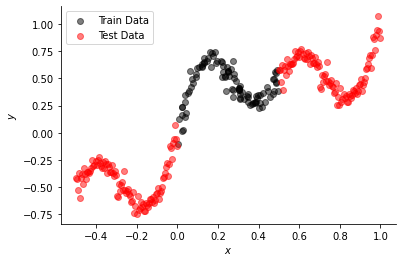

In [3]:
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [4]:
model = gaussian_mlp.gmlp(features=[32, 32], activations=[nn.elu, nn.elu], dropout_rate=[0, 0])

In [5]:
params = model.init(jax.random.PRNGKey(0), X,deterministic=True)

## Defining the log joint

In [6]:
def bnn_log_joint(params, X, y, model):
    mean,sigma = model.apply(params, X,deterministic=True)
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    # log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_likelihood = tfd.Normal(mean,sigma).log_prob(y.reshape((-1,))).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-1185.9523, dtype=float32)

In [7]:
num_warmup = 3000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)

key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)

In [8]:
num_samples = 1000
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [7]:
import pandas as pd
states,infos = pd.read_pickle("mcmc_gmlp_sindataset.pkl").values()

In [8]:
infos.is_divergent.sum()

62

Text(0.5, 1.0, 'params 0_Dense bias-0')

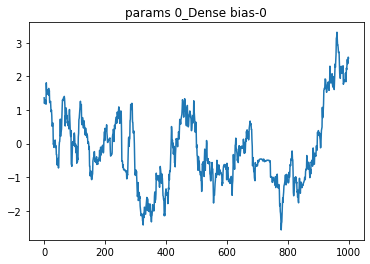

In [14]:
plt.plot(states.position['params']['0_Dense']['kernel'][:,0,10])
plt.title('params 0_Dense bias-0')

# Prediction using one test example

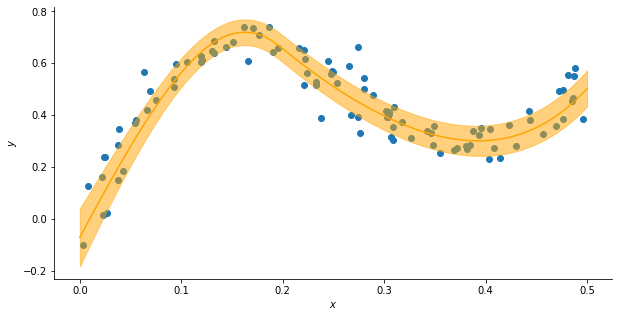

In [15]:
i=-1
one_state = tree_map(lambda x:x[i],states.position)
x_linspace = jnp.linspace(0,0.5,100).reshape((-1,1))
y_hat = model.apply(one_state, x_linspace, True)

plt.figure(figsize=(10,5))
plt.scatter(X, Y)
plt.plot(x_linspace, y_hat[0], color="orange")
mean,sigma = y_hat[0],y_hat[1]
plt.fill_between(x_linspace.squeeze(),  mean- i*sigma, mean + i*sigma, color="orange", alpha = 0.5, label = f"$\mu \pm {i}*\sigma$")

plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

# Predictions using all the states till now.

In [16]:
seed = jax.random.PRNGKey(0)
x_linspace_test = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
def one_step(carry, state):
    params_cur = state.position
    mean,sigma = model.apply(params_cur,x_linspace_test,deterministic=True)

    # if we want to simulate the generative process we are assuming, do this.
    # samples = tfd.Normal(loc=mean,scale=sigma).sample(seed=seed) 
    # return carry,samples
    
    return carry, (mean,sigma)
_, (mean_stacks,sigma_stacks) = jax.lax.scan(one_step, None, states)

In [17]:
mean,sigma = gmm_mean_var(mean_stacks, sigma_stacks)

In [18]:
x_linspace.shape
mean.shape

(200,)

In [19]:
os.chdir("../../")

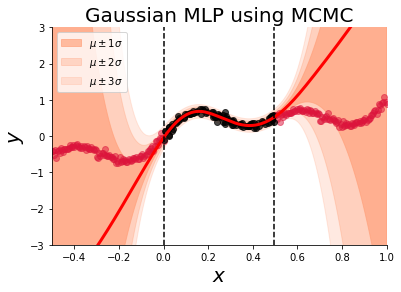

In [20]:
from utilities.plot import plot_prediction_reg

plot_prediction_reg(X,Y,jnp.append(x_test_1,x_test_2,axis=0),jnp.append(y_test_1,y_test_2,axis=0),x_linspace_test,mean,sigma,"Gaussian MLP using NUTS")

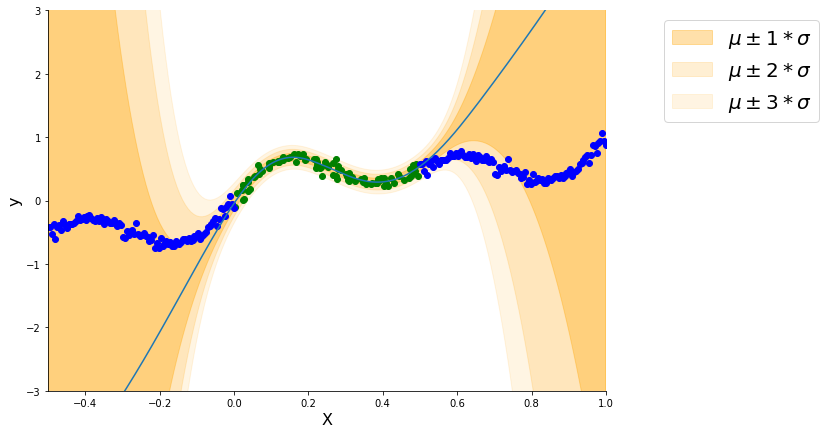

In [20]:
plt.figure(figsize=(10,7))
for i in range(1,4):
    plt.fill_between(x_linspace_test.squeeze(), mean - i*sigma, mean + i*sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")

plt.scatter(X, Y, c="g")
plt.scatter(x_test_1, y_test_1, c="b")
plt.scatter(x_test_2, y_test_2, c="b")
plt.plot(x_linspace_test, mean)

plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-0.5, 1.0)
plt.ylim(-3,3)
plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

In [40]:
y_mean = y_stacks.mean(axis=0)
y_std = y_stacks.std(axis=0)

In [1]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, c="g")
plt.scatter(x_test_1, y_test_1, c="b")
plt.scatter(x_test_2, y_test_2, c="b")
plt.plot(x_linspace_test, y_mean)

for i in range(1,4):
    plt.fill_between(
        x_linspace_test.squeeze(),
        y_mean - i*y_std,
        y_mean + i*y_std,
        color="orange", 
        alpha = 1/(i*3),
        label = f"$\mu \pm {i}*\sigma$"
        )

plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-0.5, 1.0)
plt.ylim(-7,7)
plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

NameError: name 'plt' is not defined

In [37]:
import pickle
with open("mcmc_gmlp_sindataset.pkl",'wb') as f:
    pickle.dump({"states":states,"infos":infos},f)